In [151]:
# Necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

Цель проекта: отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

In [152]:
# Functions to preprocess data

def fillnaWithMode(name):
    df[name].fillna(df[name].mode()[0], inplace=True)
    
def fillnaWithMedian(name):
    df[name].fillna(df[name].median(), inplace=True)
    
def fillnaWithNewValue(name, value):
    df[name].fillna(value, inplace=True)
    
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'], 
                        df.loc[df.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
    

In [153]:
df = pd.read_csv('stud_math.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [154]:
# While we want to predict score value let's remove all rows with missing score values as unuseful

for delrow in df.loc[df.score.isnull()].reset_index()['index']:
    df.drop(delrow, inplace=True)

In [155]:
# Now we see a strange column "studytime, granular" that was not described. But we have a column "studytime". Let's compare them.

df['studytime, granular'].value_counts()

-6.0     189
-3.0     103
-9.0      63
-12.0     27
Name: studytime, granular, dtype: int64

In [156]:
df['studytime'].value_counts()

2.0    189
1.0    103
3.0     63
4.0     27
Name: studytime, dtype: int64

In [157]:
# Hmm. They look identical for our purposes. We do not need both. I prefer to remove "studytime, granular"

df.drop('studytime, granular', inplace=True, axis=1)

In [158]:
# Now we separate numerical and categorical columns

cols_num = df.select_dtypes([np.int64,np.float64]).columns
cols_categorical = df.select_dtypes([np.object]).columns

In [159]:
# And process them independently
# Missing values in numerical columns we will replace with median

for col in cols_num:
    fillnaWithMedian(col)

In [160]:
# Missing values in categorical columns we will replace with mode
# But if missing values are more than 10% of column data we will replace them with 'Undef'

for col in cols_categorical:
    if (df[col].isnull().sum() > df[col].count()*0.1):
        fillnaWithNewValue(col, 'Undef')
    else:
        fillnaWithMode(col)

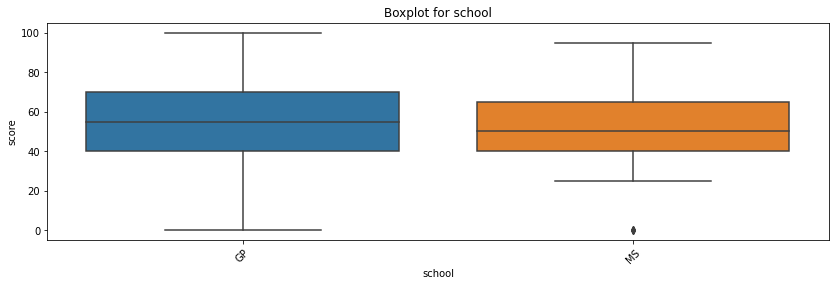

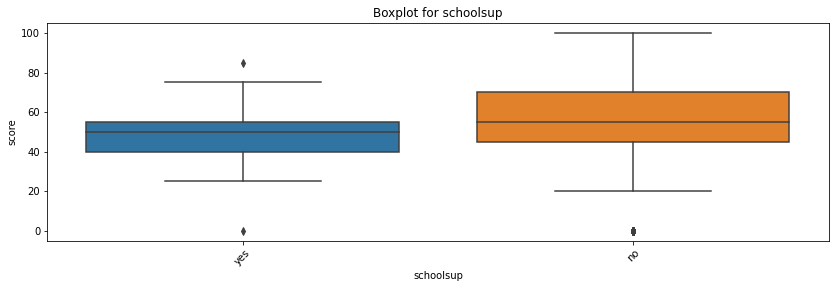

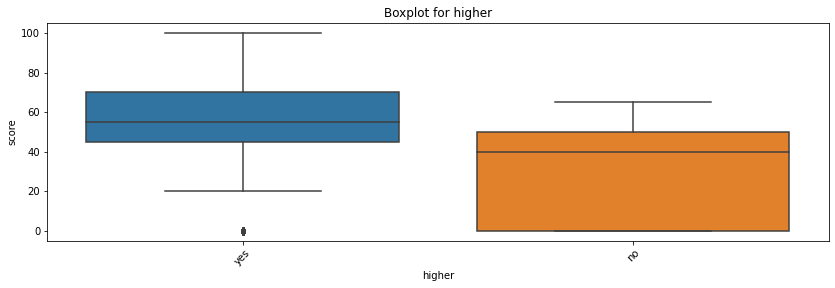

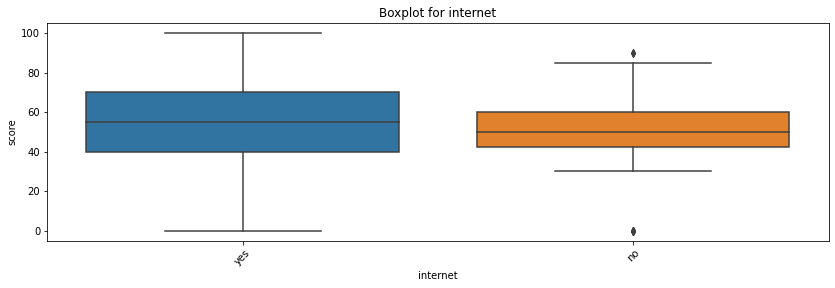

In [161]:
# Let's look at the columns having values that fills more than 85%

for col in df.columns:
    if (df[col].value_counts().reset_index()[col][0]/df[col].count() > 0.85):
        get_boxplot(col)

In [162]:
# Due to boxplots i decided to remove all reviwed columns except "higher" that shows huge correlation with score

for col in ['school', 'schoolsup', 'internet']:
    df.drop(col, inplace=True, axis=1)   

In [163]:
# Now we can find outliers for each column and look at them more precisely

for col in df[cols_num]:
    interquantile = df[col].quantile(0.75) - df[col].quantile(0.25)
    low = df[col].quantile(0.25) - 1.5 * interquantile
    high = df[col].quantile(0.75) + 1.5 * interquantile
    if (df.loc[(df[col] > int(high)) | (df[col] < int(low))][col].count() > 0):
        print(col + ' : ' + str(df.loc[(df[col] > int(high)) | (df[col] < int(low))][col].count()))

age : 1
Fedu : 1
traveltime : 7
studytime : 27
failures : 77
famrel : 184
absences : 17


In [164]:
# 22 is an outliner. But it is not unusual for dataset. Do not touch it.

df['age'].value_counts()

16    103
17     98
15     82
18     80
19     21
20      3
21      1
22      1
Name: age, dtype: int64

In [165]:
# 40 is an outliner and it looks like typo (40 = 4)

df['Fedu'].value_counts()

3.0     118
2.0     105
4.0      88
1.0      75
0.0       2
40.0      1
Name: Fedu, dtype: int64

In [166]:
# Replace 40 with 4

df['Fedu'] = df['Fedu'].apply(lambda x: 4 if x == 40 else x)

In [167]:
# 4 is an outliner. But it is not unususal for dataset

df['traveltime'].value_counts()


1.0    267
2.0     94
3.0     21
4.0      7
Name: traveltime, dtype: int64

In [168]:
# 4 is an outliner. But it is not unususal for dataset

df['studytime'].value_counts()

2.0    196
1.0    103
3.0     63
4.0     27
Name: studytime, dtype: int64

In [169]:
# 1,2,3 are outliners. But it is not unususal for dataset

df['failures'].value_counts()

0.0    312
1.0     48
2.0     15
3.0     14
Name: failures, dtype: int64

In [170]:
# We have found values (-1, 0) out of boundaries on low end 

df['famrel'].value_counts()

 4.0    205
 5.0     97
 3.0     62
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64

In [171]:
# Replace them with minimal value

df['famrel'] = df['famrel'].apply(lambda x: 1 if x < 1 else x)

<AxesSubplot:>

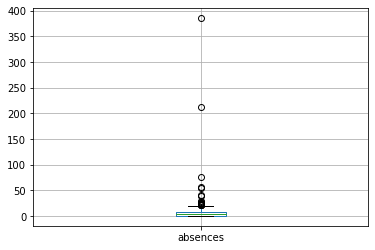

In [172]:
# Outliners are values than more than 20

df.boxplot(column=['absences'])

In [173]:
# Replace them with value 20

df['absences'] = df['absences'].apply(lambda x: 20 if x > 20 else x)

In [174]:
# Get statistical evaluated categorical columns

cols_categorical = df.select_dtypes([np.object]).columns 
for col in cols_categorical:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


In [175]:
# Every numerical column have correlation 0.3 or less (except Medu and Fedu) with target column. So all of them may be used in model.

df.corr()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
age,1.000000,-0.146405,-0.150142,0.076013,-0.018019,0.206279,0.056941,0.013994,0.121057,-0.065719,0.192897,-0.155726
Medu,-0.146405,1.000000,0.602619,-0.152597,0.079513,-0.239668,-0.003566,0.037699,0.071235,-0.054431,0.098201,0.209758
Fedu,-0.150142,0.602619,1.000000,-0.127860,0.020823,-0.259146,-0.017128,-0.008456,0.050380,0.017967,0.026027,0.124559
traveltime,0.076013,-0.152597,-0.127860,1.000000,-0.098226,0.035113,-0.029213,-0.016696,0.046390,-0.035852,-0.020253,-0.056535
studytime,-0.018019,0.079513,0.020823,-0.098226,1.000000,-0.169399,0.037950,-0.122057,-0.053554,-0.072790,-0.082602,0.114295
failures,0.206279,-0.239668,-0.259146,0.035113,-0.169399,1.000000,-0.028517,0.087558,0.101036,0.082165,0.100804,-0.337187
famrel,0.056941,-0.003566,-0.017128,-0.029213,0.037950,-0.028517,1.000000,0.164830,0.069514,0.088845,-0.085939,0.052902
freetime,0.013994,0.037699,-0.008456,-0.016696,-0.122057,0.087558,0.164830,1.000000,0.294450,0.063718,0.003876,0.017481
goout,0.121057,0.071235,0.050380,0.046390,-0.053554,0.101036,0.069514,0.294450,1.000000,-0.016427,0.084490,-0.127742
health,-0.065719,-0.054431,0.017967,-0.035852,-0.072790,0.082165,0.088845,0.063718,-0.016427,1.000000,-0.043082,-0.073208


In [179]:
# Let's get final column set for model and lok at it

cols_for_model = cols_num
cols_for_model = ['address', 'Mjob', 'higher', 'romantic']
cols_for_model.extend(cols_num)
cols_for_model.remove('score')
df_for_model = df.loc[:, cols_for_model]
df_for_model.head()

,address,Mjob,higher,romantic,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences
0,U,at_home,yes,no,18,4.0,4.0,2.0,2.0,0.0,4.0,3.0,4.0,3.0,6.0
1,U,at_home,yes,no,17,1.0,1.0,1.0,2.0,0.0,5.0,3.0,3.0,3.0,4.0
2,U,at_home,yes,no,15,1.0,1.0,1.0,2.0,3.0,4.0,3.0,2.0,3.0,10.0
3,U,health,yes,yes,15,4.0,2.0,1.0,3.0,0.0,3.0,2.0,2.0,5.0,2.0
4,U,other,yes,no,16,3.0,3.0,1.0,2.0,0.0,4.0,3.0,2.0,5.0,4.0


In [ ]:
"""
По итогам проведенного анализа можно сделать следующие выводы:
    - пропущенных значений мало, данные заполнены хорошо;
    - данные достаточно чистые: выбросов немного, а те, которые есть, в большинстве случаев
        укладываются в условия описания набора данных;
    - высокая положительная корреляция между показателями уровня образования матери и отца говорит нам о большом 
        влиянии данного показателя на формирование ячейки общества
    - также положительная корреляция уровня образования матери и отца с итоговым баллом, с учетом отрицательной корреляции этих показателей 
        с количеством внеучебных неудач, говорит о влиянии уровня образования в семье на успехи в учебе;
    - итоговый набор полей, рекомендуемых для использования в модели: 
        address, Mjob, higher, romantic, age, Medu, Fedu, traveltime, studytime, failures, famrel, freetime, goout, health, absences
"""